In [1]:
import tensorflow as tf

# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import pdb
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from src.models.basic_rnn import RNNMusicExperiment
from src.utils.midi_support import MidiSupport, load_midi_objs, load_just_that_one_test_song

In [3]:
loaded_data = load_midi_objs(num_files=5)
# loaded_data = load_just_that_one_test_song()
note_vicinity = 24
prepared_data = MidiSupport().prepare_song_note_invariant_plus_beats_and_more(loaded_data, vicinity=note_vicinity)


In [4]:
# Trying to create a dataset preparer that will shift along the input sequence giving a multi to one predictor:

def prepare_windowed_for_note_time_invariant(X, seq_length=15):
    """
    X.shape should be ((time, num_notes, architecture)
    y.shape should be ((time, num_notes, note_or_artic) # Not the y label is already shifted by one in time and corresponds to the 'next' note


    returns:
    """
    X_tensor = tf.convert_to_tensor(X)

    dataset = tf.data.Dataset.from_tensor_slices(X_tensor)
    seq_length = seq_length + 2
    windows = dataset.window(seq_length,
                                shift=1,
                                stride=1,
                                drop_remainder=True)

    sequences = windows.flat_map(lambda x: x.batch(seq_length, drop_remainder=True))

    # Split the labels
    def split_labels(sequences):
        
        inputs = sequences[1:-1, :, :]
        # Note 12:14 comes from architecture. first 24 elements are the vicinity. Label is in the middle
        labels = sequences[2:, :, 12:14]
        yyy_other = sequences[:-2, :, 12:14]
        return (inputs, yyy_other), labels

    seq_ds = sequences.map(split_labels)
                            # num_parallel_calls=tf.data.AUTOTUNE)

    return seq_ds

In [5]:
seq_ds = prepare_windowed_for_note_time_invariant(prepared_data[0], seq_length=128)

2022-01-12 16:47:35.821217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-12 16:47:35.821357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 21.33 GB



In [6]:
class SwapLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(SwapLayer, self).__init__()

    def call(self, orig_tensor, training=None):
        swapped = tf.transpose(orig_tensor, [1, 0, 2])
        return swapped

In [7]:
class ResetModelState(tf.keras.callbacks.Callback):

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        if batch % 4 == 0:
            pass
            # # print("...Training: end of batch {}".format(batch))
            # self.model.layers[1].reset_states()
            # self.model.layers[5].reset_states()


In [146]:
def model_new(learning_rate=0.001, total_vicinity=28, dropout=0, recurrent_dropout=0):

    elements_per_time_step = 4

    # Time layers get input:
    # [Batch(notes total 128 batches), beats(whatever our total song length is), architecture dimension]
    input_shape = (elements_per_time_step, total_vicinity)

    model = tf.keras.Sequential()

    # Time layers get input:
    # Recursion along time dimension
    # " # time_inputs is a matrix (time, batch/note, input_per_note)" 
    #                         =>  (batch/note, time, input_per_note)
    #                         batch dimension is where all our extra data goes. Notes are added here
    # For a batch_amount of notes, we take an arbitrarly length time segment and train. In the batch dimensions we have the other notes for this segment and the other segments
    # [batch_amount of notes (should be 128), beats(arbitrary time sequence), architecture dimension]
    model.add(tf.keras.Input(shape=input_shape, batch_size=4))
    model.add(tf.keras.layers.LSTM(200,  return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    # model.add(tf.keras.layers.LSTM(200,  return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    model.add(SwapLayer())

    # Note layers get input:
    # Recursion along the note dimension
    # "# Transpose to be (note, batch/time, hidden_states)"
    #               =>  (batch/time, note, input_per_note)
    #                  batch dimension is where all our extra data goes. All changes in time within temporal sequences and across different temporal sequences go here.
    # For a single temporal sequence step, we take all notes and train. In the batch dimensions all other changes go there
    # [beats(arbitrary time sequence), Batch(notes total 128 batches), 300 node time layer output]
    # model.add(tf.keras.layers.LSTM(100,  return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    model.add(tf.keras.layers.LSTM(100,  return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    model.add(tf.keras.layers.Dense(2, activation="sigmoid"))

    model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
            loss=loss,
            optimizer=optimizer,
            # metrics=[tf.keras.metrics.BinaryCrossentropy()
            metrics=["mse"
            ]
        )
    return model, None

In [11]:
def model_note_time(learning_rate=0.001, total_vicinity=28, dropout=0, recurrent_dropout=0):

    elements_per_time_step = 128

    # Time layers get input:
    # [Batch(notes total 128 batches), beats(whatever our total song length is), architecture dimension]
    input_shape = (elements_per_time_step, total_vicinity)
    input_shape_b = (elements_per_time_step, 2)

    model = tf.keras.Sequential()

    # Time layers get input:
    # Recursion along time dimension
    # Note from Daniel Johnson Code: " # time_inputs is a matrix (time, batch/note, input_per_note)" 
    #                 Tensorflow wants batch as 0th dimension=>  (batch/note, time, input_per_note)
    #                         batch dimension is where all our extra data goes. Notes are added here
    # For a batch_amount of notes, we take an arbitrarly length time segment and train. In the batch dimensions we have the other notes for this segment and the other segments
    # [batch_amount of notes (should be 128), beats(arbitrary time sequence), architecture dimension]
    input_a = tf.keras.Input(shape=input_shape,  name="input_a")
    input_b = tf.keras.Input(shape=input_shape_b, name="input_b")

    mod_time = SwapLayer()(input_a)
    mod_time = tf.keras.layers.LSTM(200, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=False)(mod_time)
    mod_time = SwapLayer()(mod_time)
    mod_time = tf.keras.Model(inputs=input_a, outputs=mod_time)
    # model.add(tf.keras.layers.LSTM(200,  unroll=True, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout, stateful=True))
    

    combined = tf.keras.layers.concatenate([mod_time.output, input_b])

    

    mod_notes = tf.keras.layers.LSTM(100, return_sequences=True, dropout=dropout, stateful=False)(combined)
    mod_notes = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation="sigmoid"))(mod_notes)
    # mod_notes = SwapLayer()(mod_notes)
    

    model = tf.keras.Model(inputs=[input_a, input_b], outputs=[mod_notes])

    model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
            loss=loss,
            optimizer=optimizer,
            # metrics=[tf.keras.metrics.BinaryCrossentropy()
            metrics=["mse"
            ]
        )
    return model, None

In [30]:
prepared_data[1].shape

(10415, 128, 2)

In [31]:

full_len = prepared_data[0].shape[0]
even_mul_length = (full_len//128) * 128
xxx = prepared_data[0][:even_mul_length, :, :]
yyy = prepared_data[1][:even_mul_length, :, :]
s_shape = yyy.shape[0]

yyy_other = prepared_data[1][:even_mul_length, :, :].reshape((s_shape*128, 2))
yyy_other = np.concatenate([np.zeros((2,2)), yyy_other[2:, :]])
yyy_other = yyy_other.reshape((s_shape, 128, 2))

In [16]:


class haltCallback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        if(logs.get('loss') <= 0.0035):
            print("\n\n\nReached 0.035 loss value so cancelling training!\n\n\n")
            self.model.stop_training = True

# model, callbakcs = model_new(total_vicinity=53, learning_rate=0.0001, dropout=0, recurrent_dropout=0)
# model, callbakcs = model_note_time(total_vicinity=53, learning_rate=0.001, dropout=0)

seq_ds.shuffle(buffer_size=100)
history = model.fit(seq_ds,
    epochs=3,
    callbacks=[haltCallback()],
)

Epoch 1/3
    206/Unknown - 22s 105ms/step - loss: 0.0293 - mse: 0.0078

KeyboardInterrupt: 

In [416]:
xxx.shape, yyy_other.shape, yyy_pred.shape

((1152, 128, 53), (1152, 128, 2), (1152, 2))

In [33]:
# Predicting the whole thing!
yyy_pred = model.predict([xxx[:512, :, :], yyy_other[:512, :, :]], batch_size=128)

2022-01-12 16:59:37.331477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 16:59:37.403482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 16:59:37.593418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [203]:
yyy_other_rand = np.random.uniform(size=(1152, 128, 2))
yyy_rand = np.random.uniform(size=(1152, 128, 2))
yyy_other.shape, yyy.shape, yyy_other_rand.shape, yyy_rand.shape

((1152, 128, 2), (1152, 128, 2), (1152, 128, 2), (1152, 128, 2))

In [31]:
yyy_pred_128.shape, yyy.shape

((128, 128, 2), (1152, 128, 2))

In [87]:

t = pd.DataFrame(yyy[127, :, :]).T
t

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [117]:
np.allclose(input_notes_reshape, xxx[:128, :, :]), np.allclose(input_notes_b_reshape[:-1, :, :], yyy_other_test[:-1, :, :]), pd.DataFrame(probs[-1, 50:55, :]).T

NameError: name 'input_notes_reshape' is not defined

In [118]:
model.reset_states()

In [127]:
# Predicting with part of the sequence as zero, This is reference
yyy_other_test = np.copy(yyy_other[:128, :, :])
# yyy_other_test[:, :, :] = 1
yyy_pred_128 = model.predict([xxx[:128, :, :], yyy_other_test], batch_size=128)
t1 = pd.DataFrame(yyy_pred_128[-1, 50:55, :]).T
t1

,0,1,2,3,4
0,0.000074,0.968272,0.003581,0.001176,0.904150
1,0.000186,0.002585,0.077061,0.000253,0.000843


In [93]:
pd.DataFrame(yyy_other_test[:, 51, 0]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [145]:
# Predicting with part of the sequence as zero, Does this change the sequences after

yyy_other_test[:, 52:, :] = 5
yyy_pred_128 = model.predict([in_1_works, in_2_works], batch_size=128)
t2 = pd.DataFrame(yyy_pred_128[-1, 50:55, :]).T
t2

,0,1,2,3,4
0,0.000074,0.968272,0.003581,0.001176,0.904150
1,0.000186,0.002585,0.077061,0.000253,0.000843


In [77]:
t1 - t2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.904401,-0.961268,-0.086352,-0.919510,-0.971252,-0.926189,-0.316316,-0.976958,-0.898594,-0.969709,-0.914489,-0.984217,-0.890741,-0.969107,-0.978752,-0.942432,-0.975813,-0.912694,-0.980514,-0.967790,-0.946658,-0.985522,-0.962826,-0.982882,-0.919246,-0.948075,-0.973990,-0.954342,-0.982780,-0.942432,-0.982106,-0.965349,-0.954792,-0.973493,-0.956412,-0.974398,-0.948781,-0.969661,-0.974615,-0.957518,-0.969155,-0.949174,-0.983146,-0.967395,-0.960453,-0.973156,-0.957587,-0.973793,-0.955062,-0.969997,-0.973128,-0.957794,-0.969867,-0.945888,-0.979659,-0.968132,-0.964194,-0.971846,-0.960371,-0.972176,-0.959829,-0.969376,-0.971916,-0.961462,-0.968501,-0.946000,-0.977267,-0.967788,-0.966247,-0.971512,-0.961762,-0.970034,-0.961952,-0.968241,-0.971218,-0.266749
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.904195,-0.605308,-0.336394,-0.895378,-0.339387,-0.591806,-0.303652,-0.288393,-0.499248,-0.239325,-0.629965,-0.276897,-0.600849,-0.555058,-0.406869,-0.886218,-0.365612,-0.839957,-0.494135,-0.385299,-0.582199,-0.345663,-0.786780,-0.419374,-0.907458,-0.757353,-0.434162,-0.532491,-0.281123,-0.652110,-0.395957,-0.360869,-0.548992,-0.390048,-0.562306,-0.381875,-0.531865,-0.476724,-0.393898,-0.549205,-0.352250,-0.628128,-0.401952,-0.364556,-0.477216,-0.373407,-0.499873,-0.357217,-0.449820,-0.410289,-0.365936,-0.481438,-0.316522,-0.591270,-0.370946,-0.342189,-0.404472,-0.353707,-0.428487,-0.334673,-0.379488,-0.366199,-0.340791,-0.401967,-0.293290,-0.540906,-0.336844,-0.320539,-0.351623,-0.292518,-0.364800,-0.313734,-0.332860,-0.336116,-0.295927,-0.112349


In [555]:
xxx.shape, yyy.shape, yyy_pred.shape

((1152, 128, 53), (1152, 128, 2), (1152, 128, 2))

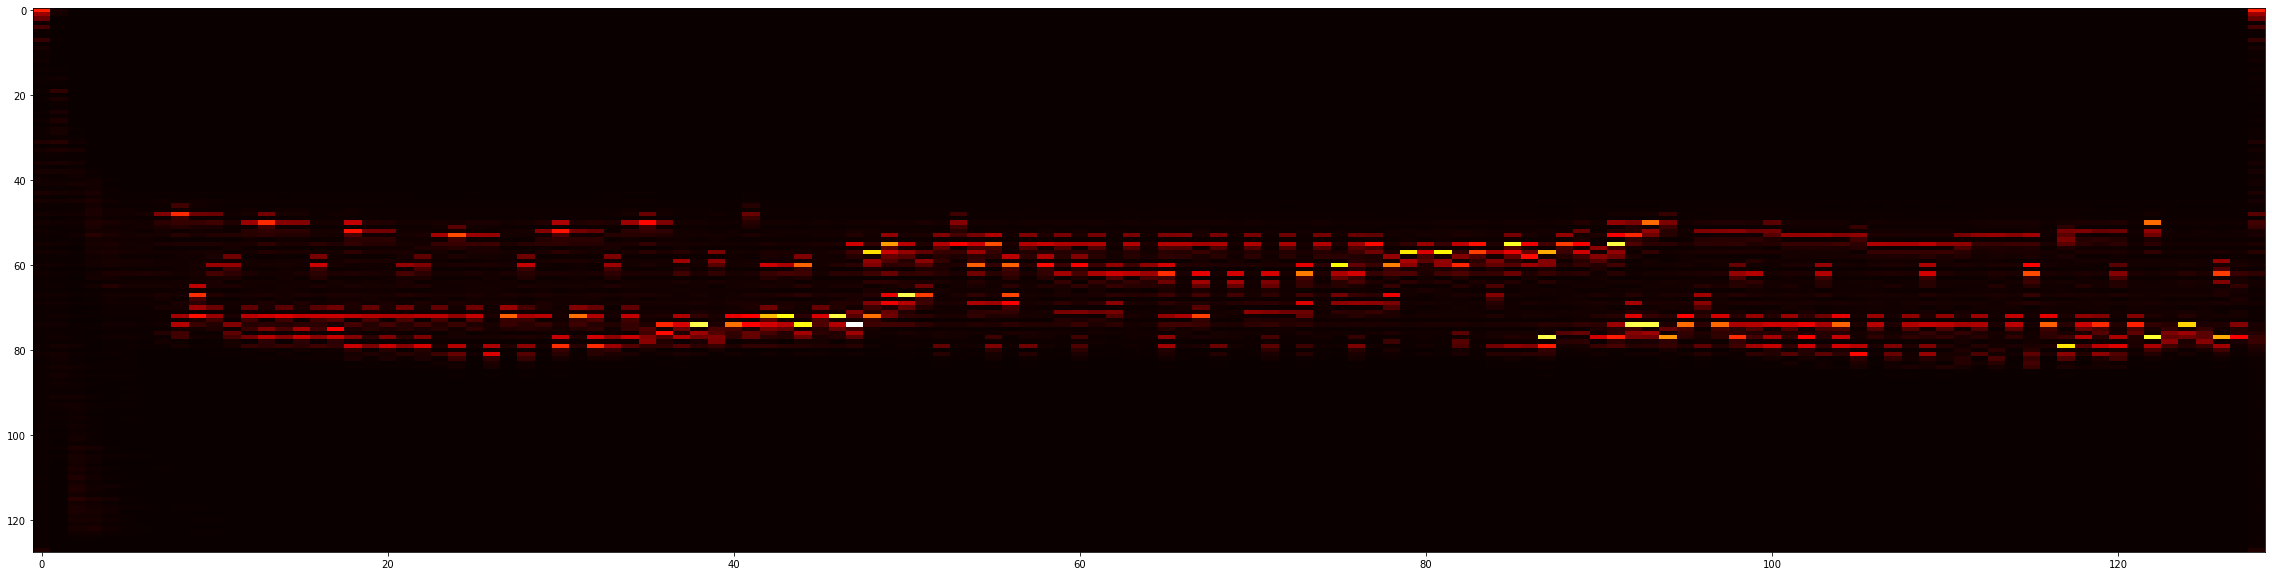

In [34]:
import matplotlib.pyplot as plt

# data = yyy_pred.reshape((1152, 128, 2))
data = yyy_pred
data = data[:129,  :, 1]
plt.rcParams["figure.figsize"] = (40,10)
plt.imshow(data.T, cmap='hot', interpolation='nearest', aspect="auto")

In [ ]:
import matplotlib.pyplot as plt

num_beats = 128
offset = 0
input_notes = xxx[offset:offset+num_beats, :, :]
# data = yyy_pred.reshape((1152, 128, 2))
data = input_notes[:, -1, -4:]
plt.rcParams["figure.figsize"] = (40,10)
plt.imshow(data.T, cmap='hot', interpolation='nearest', aspect="auto")

In [133]:
# Good one
yyy_other_test = np.copy(yyy_other[:128, :, :])

# Info
num_beats = 128
num_notes = 128


# Other for predict
input_notes_b = yyy_other[0:128, :, :]

input_notes_b_reshape = input_notes_b

in_2_works[-1, 51, :]


np.allclose(input_notes_b_reshape[:, :50, :], yyy_other_test[:, :50, :])
np.allclose(input_notes_b_reshape[:-1, :, :], in_2_works[:-1, :, :])
np.allclose(input_notes_b_reshape[-1, :51, :], in_2_works[-1, :51, :])
np.allclose(input_notes_b_reshape_tst, in_2_works)
input_notes_b_reshape_tst[-1, 52:, :] = input_notes_b_reshape[-1, 52:, :]

True

In [17]:
def predict_time_note_model(prepared_training_data, size=16):
    reshaped_train_data = prepared_training_data
    num_beats=128
    num_notes = 128
    total_vicinity = 53
    note_vicinity=24
    
    outputs = []
    all_probs = []
    
    offset = np.random.choice(range(len(reshaped_train_data)))
    # offset = 0

    input_notes_reshape = reshaped_train_data[offset+1:offset+1+num_beats, :, :]
    input_notes_b_reshape = reshaped_train_data[offset:offset+num_beats, :, 12:14]

    last_beats =[str(x) for x in input_notes_reshape[-1, -1, -4:]]
    last_beats_int = int("".join(last_beats), 2)


    for l in range(size):

        out_arr = np.zeros((num_notes,2))
        probs_arr = np.zeros((num_notes,2))

    
        for i in range(num_notes):
            
            if i == 0:
                probs = model.predict([input_notes_reshape, input_notes_b_reshape], batch_size=128)
                
                # Sub Model
                intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                                outputs=model.layers[3].output)
                intermediate_output = intermediate_layer_model.predict([input_notes_reshape, input_notes_b_reshape], batch_size=128)
                input_shape = (128, 200)
                sub_model = tf.keras.Sequential()
                new_input = tf.keras.Input(shape=input_shape,  name="new_input")
                old_input_b = model.layers[4]
                concat_lay = model.layers[5]([new_input, old_input_b.output])
                mod_notes = model.layers[6](concat_lay)
                mod_notes = model.layers[7](mod_notes)
                sub_model = tf.keras.Model(inputs=[new_input, old_input_b.input], outputs=[mod_notes])

            else:
                probs = sub_model.predict([intermediate_output[-1:, :, :], input_notes_b_reshape[-1:, :, :]], batch_size=128)
        
            last_new_play_artic_probs = probs[-1, i, :]
            last_new_play_artic = np.random.binomial(1, last_new_play_artic_probs, size=None).reshape((1, 2))
            

            if i < (num_notes - 1):
                input_notes_b_reshape[-1, i:i+1, :] = last_new_play_artic
            else:
                input_notes_b_reshape = np.concatenate([input_notes_b_reshape[1:, :, :], np.zeros((1, num_beats, 2))], axis=0)

            probs_arr[i, 0] = last_new_play_artic_probs[0]
            probs_arr[i, 1] = last_new_play_artic_probs[1]
            out_arr[i, 0] = last_new_play_artic[0, 0]
            out_arr[i, 1] = last_new_play_artic[0, 1]


        out = out_arr.reshape((256,1))
        probs = probs_arr.reshape((256,1))


        # Need to window across out to get the input form again.
        out = out.reshape((256,1))
        probs = probs.reshape((256,))
        outputs.append(out.reshape(256,))
        all_probs.append(probs)

        # note_vicinity = total_vicinity-4-12-12-1
        next_pred, _, _ = MidiSupport().windowed_data_across_notes_time(out, mask_length_x=note_vicinity, return_labels=False)# Return (total_vicinity, 128)

        # Get array of Midi values for each note value
        n_notes = 128
        midi_row = MidiSupport().add_midi_value(next_pred, n_notes)

        # Get array of one hot encoded pitch values for each note value
        pitchclass_rows = MidiSupport().calculate_pitchclass(midi_row, next_pred)

        # Add total_pitch count repeated for each note window
        previous_context = MidiSupport().build_context(next_pred, midi_row, pitchclass_rows)

        midi_row = midi_row.reshape((1, -1))
        next_pred = np.vstack((next_pred, midi_row, pitchclass_rows, previous_context))
        
        last_beats_int += 1
        last_beats_int = last_beats_int%16
        next_beats_ind = np.array([int(x) for x in bin(last_beats_int)[2:].zfill(4)])
        next_beats_ind = next_beats_ind.reshape((4, 1))
        next_beats_ind = np.repeat(next_beats_ind, num_notes, axis=1)

        # TODO, check if beat is correctly increasing: might need to flip it before adding
        last_new_note = np.concatenate([next_pred, next_beats_ind])
        last_new_note = last_new_note[np.newaxis, :, :] # Shape now  (1, 28, 128)
        last_new_note = np.swapaxes(last_new_note, 1, 2) # Shape now  (1, 128, 28)
        # last_new_note = np.swapaxes(last_new_note, 0, 1) # Shape now  (128, 1, 28)
        
        together = np.concatenate([input_notes_reshape[1:, :, :], last_new_note], axis=0)
        input_notes_reshape = together

    outputs_joined = pd.DataFrame(outputs)
    all_probs_joined = pd.DataFrame(all_probs)
    return outputs_joined, all_probs_joined


In [185]:
# model.layers[3].output, model.layers[4].input
model.input

[<KerasTensor: shape=(None, 128, 53) dtype=float32 (created by layer 'input_a')>,
 <KerasTensor: shape=(None, 128, 2) dtype=float32 (created by layer 'input_b')>]

In [ ]:
np.allclose(input_notes_reshape, xxx[:128, :, :])
np.allclose(input_notes_b_reshape[:-1, :, :], yyy_other_test[:-1, :, :])
pd.DataFrame(probs[-1, 50:55, :]).T

In [18]:
outputs_joined, all_probs_joined = predict_time_note_model(xxx, size=16)

2022-01-12 16:51:46.223489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 16:51:46.298809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 16:51:46.475318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 16:51:46.725205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 16:51:46.764312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 16:51:47.089796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-12 16:51:47.139146: I tensorflow/core/grappler/optimizers/cust

In [251]:
seq_ds.shuffle(buffer_size=100)
for x in seq_ds.take(1):
    xxxtst = x[0][0]

In [113]:
out.T.shape, input_notes_reshape[-1, :, 12:14].reshape((1, 256)).shape

((1, 256), (1, 256))

In [114]:
pd.DataFrame(out.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
pd.DataFrame(input_notes_reshape[-1, :, 12:14].reshape((1, 256)))

NameError: name 'input_notes_reshape' is not defined

In [142]:
input_notes_reshape.shape, input_notes_b_reshape.shape, input_notes_reshape[:, -1:, :].shape, input_notes_b_reshape[:, -1:, :].shape

((256, 32, 53), (256, 32, 2), (256, 1, 53), (256, 1, 2))

In [137]:
model.layers[0].output, model.layers[2].output

(<KerasTensor: shape=(32, 32, 53) dtype=float32 (created by layer 'input_a')>,
 <KerasTensor: shape=(32, 32, 200) dtype=float32 (created by layer 'swap_layer_10')>)

In [141]:
# probs = model.predict([input_notes_reshape[:, -1:, :], input_notes_b_reshape[:, -1:, :]], batch_size=1)
probs = model.predict([input_notes_reshape, input_notes_b_reshape], batch_size=32)
probs.shape
# input_notes_reshape.shape, input_notes_b_reshape.shape

(256, 32, 2)

In [76]:
input_notes_reshape.shape, input_notes_b_reshape.shape

((60, 32, 53), (60, 32, 2))

In [77]:
xxx_2.shape, yyy_other_2.shape

((4608, 32, 53), (4608, 32, 2))

In [80]:
batch_sequence_size

32

In [100]:
outputs_joined.shape

(10, 256)

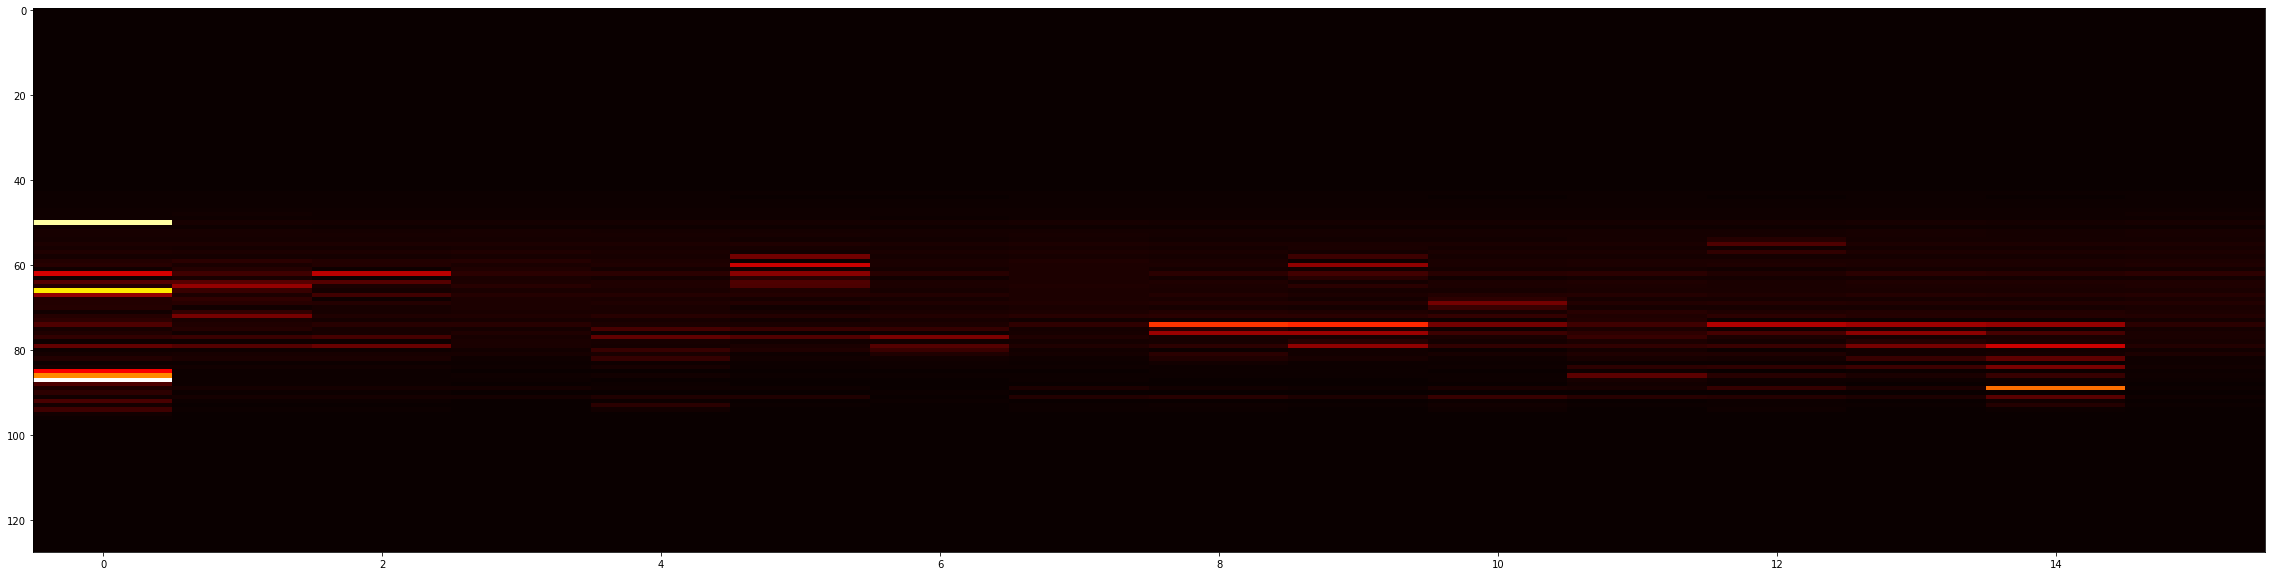

In [22]:
import matplotlib.pyplot as plt
from src.utils.visualization import note_and_artic_to_one

# data = yyy_pred.reshape((1152, 128, 2))
# data = all_probs_joined[:,  :, 0]

# all_probs_joined, outputs_joined

# outputs_joined, c 

data = note_and_artic_to_one(all_probs_joined, what="artic")
plt.rcParams["figure.figsize"] = (40,10)
plt.imshow(data, cmap='hot', interpolation='nearest', aspect="auto")

In [183]:
pd.DataFrame(outputs_joined)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0

In [89]:
import imp
import src.models.basic_rnn
import src.utils.midi_support
imp.reload(src.models.basic_rnn)
imp.reload(src.utils.midi_support)
from src.models.basic_rnn import RNNMusicExperimentTen, RNNMusicExperimentEleven

Trying Exp 4
Model: "model_597"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_a (InputLayer)           [(None, 128, 53)]    0           []                               
                                                                                                  
 swap_layer_32 (SwapLayer)      (128, None, 53)      0           ['input_a[0][0]']                
                                                                                                  
 lstm_32 (LSTM)                 (128, None, 200)     203200      ['swap_layer_32[0][0]']          
                                                                                                  
 swap_layer_33 (SwapLayer)      (None, 128, 200)     0           ['lstm_32[0][0]']                
                                                                             

/Users/trevorgordon/.venvs/sandbox_tf/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Training...
    581/Unknown - 215s 369ms/step - loss: 0.0400 - mse: 0.0102


Reached 0.04 loss value so cancelling training!



582/582 [==============================] - 216s 369ms/step - loss: 0.0400 - mse: 0.0102
Predicting data...
Saving data...


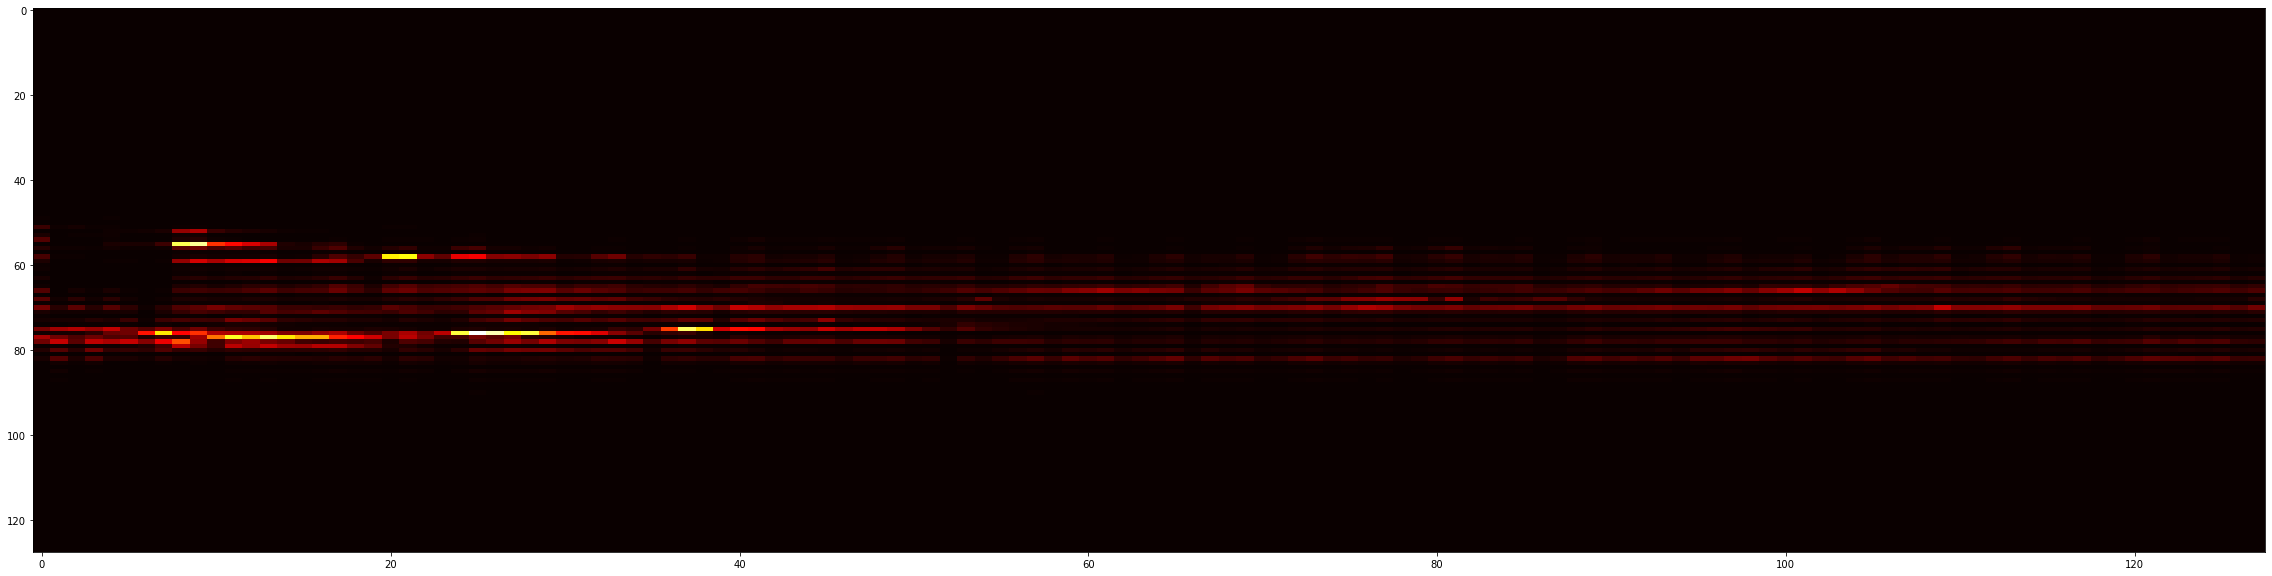

In [266]:
print("Trying Exp 4")
exp = RNNMusicExperimentTen()
exp.run()

In [259]:
xxxtst.numpy().shape

(128, 128, 53)

In [260]:
from src.models.basic_rnn import predict_time_note_model

ValueError: Data cardinality is ambiguous:
  x sizes: 127, 128
Make sure all arrays contain the same number of samples.

In [37]:
import pickle
with open("/Users/trevorgordon/Downloads/MuseData.pickle", "rb") as fp:
    tst = pickle.load(fp)

In [49]:
len(tst["test"]), len(tst["test"][0])

(124, 151)

In [56]:
import glob
num_files = 15
# filenames = glob.glob(str("music_generation_rnn/training_data/classical/**/**/*.mid*"))
filenames = glob.glob(str('/Users/trevorgordon/Downloads/MuseData/train/*.mid*'))
if len(filenames) == 0:
    raise Exception("Couldn't find the downloaded data :(")

ms = MidiSupport()
midi_objs = []
for f in filenames[:num_files]:
    try:
        mf_i = ms.load_midi_file(f)
        midi_objs.append(mf_i)
    except:
        print(f"couldn't load {f}")
midi_objs

couldn't load /Users/trevorgordon/Downloads/MuseData/train/bach.chorals.0286_midip_01.mid
couldn't load /Users/trevorgordon/Downloads/MuseData/train/bach.chorals.0309_midip_01.mid
couldn't load /Users/trevorgordon/Downloads/MuseData/train/mozart.qrtets.k080_midip_02.mid
couldn't load /Users/trevorgordon/Downloads/MuseData/train/corelli.trio-op2.op2n08_midip_01.mid
couldn't load /Users/trevorgordon/Downloads/MuseData/train/bach.cant.0046_midi1_04.mid
couldn't load /Users/trevorgordon/Downloads/MuseData/train/mozart.qrtets.k159_midi1_01.mid
couldn't load /Users/trevorgordon/Downloads/MuseData/train/mozart.qrtets.k080_midip_03.mid
couldn't load /Users/trevorgordon/Downloads/MuseData/train/bach.keybd-wtc-ii.0881_midip_01.mid


In [63]:

play_articulated = MidiSupport().all_midi_obj_to_play_articulate(midi_objs)
X_before_window, y_new = MidiSupport().prepare_song_note_invariant_plus_beats_and_more(midi_objs, vicinity=24)
seq_ds_new = MidiSupport().prepare_windowed_for_note_time_invariant(X_before_window, seq_length=128)

In [68]:
play_articulated.shape

(256, 4256)

In [70]:
play_articulated.iloc[:, :]

0    1    2    3    4    5    6    7    8    9    10   11   12   13   \
0      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
251    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
252    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
253    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
254    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
255    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

     14   15   16   17   18   19   20   21   22   23   24   25   26   27   \
0      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
251    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
252    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
253    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
254    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
255    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

     28   29   30   31   32   33   34   35   36   37   38   39   40   41   \
0      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
251    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
252    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
253    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
254    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
255    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

     42   43   44   45   46   47   48   49   50   51   52   53   54   55   \
0      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
251    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
252    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
253    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
254    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
255    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

     56   57   58   59   60   61   62   63   64   65   66   67   68   69   \
0      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2      0    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [ ]:
import matplotlib.pyplot as plt

aaa = 0
timenum = 32
data = play_articulated.iloc[:, aaa:aaa+128].T
plt.rcParams["figure.figsize"] = (40,10)
plt.imshow(data.T, cmap='hot', interpolation='nearest', aspect="auto")

In [88]:
from src.models.basic_rnn import model_note_time, RNNMusicExperimentEleven
mm, _ = model_note_time()

ImportError: cannot import name 'RNNMusicExperimentEleven' from 'src.models.basic_rnn' (/Users/trevorgordon/Library/Mobile Documents/com~apple~CloudDocs/Documents/root/Columbia/Spring2022/NNDL/music_generation_rnn/src/models/basic_rnn.py)

In [86]:
mm.load_weights("/Users/trevorgordon/Library/Mobile Documents/com~apple~CloudDocs/Documents/root/Columbia/Spring2022/NNDL/music_generation_rnn/models/latest")

2022-01-13 09:12:13.609166: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open /Users/trevorgordon/Library/Mobile Documents/com~apple~CloudDocs/Documents/root/Columbia/Spring2022/NNDL/music_generation_rnn/models/latest: FAILED_PRECONDITION: /Users/trevorgordon/Library/Mobile Documents/com~apple~CloudDocs/Documents/root/Columbia/Spring2022/NNDL/music_generation_rnn/models/latest; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [105]:
exp = RNNMusicExperimentEleven(num_music_files=100)

In [106]:
exp.model = mm

In [122]:
def load_nottingham_objs_test(data_dir="", num_files=15, seq_length=15):

    # filenames = glob.glob(str("music_generation_rnn/training_data/classical/**/**/*.mid*"))
    filenames = glob.glob(str('/Users/trevorgordon/Downloads/MuseData/test/*.mid*'))
    if len(filenames) == 0:
        raise Exception("Couldn't find the downloaded data :(")

    ms = MidiSupport()
    midi_objs = []
    for f in filenames[:num_files]:
        try:
            mf_i = ms.load_midi_file(f)
            midi_objs.append(mf_i)
        except:
            continue
    return midi_objs

def load_ylang_ylang(data_dir="", num_files=15, seq_length=15):

    # filenames = glob.glob(str("music_generation_rnn/training_data/classical/**/**/*.mid*"))
    filenames = glob.glob('/Users/trevorgordon/Library/Mobile Documents/com~apple~CloudDocs/Documents/root/Columbia/Spring2022/NNDL/music_generation_rnn/ylang_ylang.mid')
    if len(filenames) == 0:
        raise Exception(
            "Couldn't specific file 'ylang_ylang' that this experiment is based on. Please download with terminal command wget \"https://tinyurl.com/mpkou9t\""
        )

    ms = MidiSupport()

    num_files = num_files
    midi_objs = []
    # Adding known song for training
    filenames = ["mpkou9t"]
    for f in filenames[:num_files]:
        mf_i = ms.load_midi_file(f)

        midi_objs.append(mf_i)

    return midi_objs

# loaded_test_midi = load_nottingham_objs_test()
# prepared_data_test = exp.prepare_data(loaded_test_midi)
ylang_ylang = load_ylang_ylang()

Exception: Couldn't specific file 'ylang_ylang' that this experiment is based on. Please download with terminal command wget "https://tinyurl.com/mpkou9t"

In [107]:
loaded_midi = exp.load_data()


loading nottingham


In [ ]:
exp.prepared_data = prepared_data_test
exp.prepared_data.shuffle(buffer_size=100)
exp.predict_and_save_data("predicting_using_test_data2")

In [111]:
exp.callbacks = None
exp.common_config["dropout"] = 0.5
exp.train_model(exp.prepared_data)

    461/Unknown - 49s 105ms/step - loss: 0.0021 - mse: 3.2732e-04

KeyboardInterrupt: 

In [103]:
exp.common_config["dropout"]

0

In [110]:
exp.prepared_data.shuffle(buffer_size=100)

<ShuffleDataset shapes: (((128, 128, 53), (128, 128, 2)), (128, 128, 2)), types: ((tf.int64, tf.int64), tf.int64)>